In [41]:
import pandas as pd, numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt, seaborn as sns
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))
RANDOM_SEED = 42

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\WINDOWS-10\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [42]:
tx = pd.read_csv("C:\\Users\\WINDOWS-10\\Desktop\\job\\intern\\APPLIED\\money lion\\machine learning scientist\\bank_transaction.csv", parse_dates=['txn_date'])
profile = pd.read_csv("C:\\Users\\WINDOWS-10\\Desktop\\job\\intern\\APPLIED\\money lion\\machine learning scientist\\user_profile.csv")
print(tx.shape, profile.shape)
tx.head()
tx.info()
tx['category'].value_counts().head(20)


(258779, 8) (1000, 7)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 258779 entries, 0 to 258778
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   client_id    258779 non-null  int64         
 1   bank_id      258779 non-null  int64         
 2   account_id   258779 non-null  int64         
 3   txn_id       258779 non-null  int64         
 4   txn_date     258779 non-null  datetime64[ns]
 5   description  258779 non-null  object        
 6   amount       258779 non-null  float64       
 7   category     258522 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(4), object(2)
memory usage: 15.8+ MB


category
Uncategorized                 29392
Third Party                   28714
Restaurants                   26367
Transfer Credit               21561
Loans                         19605
Convenience Stores            18630
Supermarkets and Groceries    16750
Transfer Debit                15114
Gas Stations                  12919
Internal Account Transfer     11983
Payroll                        8100
Shops                          7418
Bank Fees                      6432
Transfer                       6275
ATM                            5672
Transfer Deposit               4976
Digital Entertainment          4525
Utilities                      4118
Clothing and Accessories       3190
Department Stores              2002
Name: count, dtype: int64

In [43]:
profile = profile.rename(columns={
    "CLIENT_ID": "client_id",
    "IS_INTERESTED_INVESTMENT": "is_interested_investment",
    "IS_INTERESTED_BUILD_CREDIT": "is_interested_build_credit",
    "IS_INTERESTED_INCREASE_INCOME": "is_interested_increase_income",
    "IS_INTERESTED_PAY_OFF_DEBT": "is_interested_pay_off_debt",
    "IS_INTERESTED_MANAGE_SPENDING": "is_interested_manage_spending",
    "IS_INTERESTED_GROW_SAVINGS": "is_interested_grow_savings"
})



In [44]:
# missing values
tx.isnull().sum()
# duplicates
tx['txn_id'].duplicated().sum()
# class balance
tx['category'].value_counts(normalize=True).head(30)
# amount summary
tx['amount'].describe()
# sample descriptions per category
for cat in tx['category'].value_counts().index[:5]:
    print("=== ",cat)
    print(tx[tx['category']==cat]['description'].sample(3).values)


===  Uncategorized
['EASYPAY FINANCE DUVERA' 'Sezzle*Sean*Mnt1 G*P4'
 'EMPOWER 3168 230901 Empower Advance JasonDurfee']
===  Third Party
['Cash App' 'Cash App*Joanna E M'
 'PMNT SENT 0821 CASH APP*Maryse Hemant 3168 CA 31683168']
===  Restaurants
['Point of Sale Debit L340 DATE 06-19 CHICK-FIL-A #01106WILMINGTON'
 'STARBUCKS 1036 SEATTLE WA'
 'PURCHASE AUTHORIZED ON 07/04 BURGER KING #4511 Maryse HemantA FL S303185656448216 111']
===  Transfer Credit
['Transfer from Chime Savings Account' 'ONLINE TRANSFER FROM 152'
 'Transfer from CB']
===  Loans
['MoneyLion Instacash New York RTPCREDIT' 'Transfer MoneyLion Instacash'
 'Dave Inc Los Maryse Hemantes CA 09/22']


In [45]:
import re
def clean_text(s):
    if pd.isna(s): return ""
    s = str(s).lower()
    s = re.sub(r'\d{4,}', ' <NUM> ', s)  # redact long numbers
    s = re.sub(r'[^a-z0-9\s]', ' ', s)
    s = re.sub(r'\s+', ' ', s).strip()
    return s

tx['desc_clean'] = tx['description'].apply(clean_text)


In [46]:
tx['is_credit'] = (tx['amount'] > 0).astype(int)
tx['dayofweek'] = tx['txn_date'].dt.dayofweek
tx['is_weekend'] = tx['dayofweek'].isin([5,6]).astype(int)

# join user profile if useful
tx = tx.merge(profile, on="client_id", how="left")



In [51]:
print("Missing values in X:\n", X.isna().sum())
print("\nMissing values in y:\n", y.isna().sum())

tx['category'] = tx['category'].fillna("Unknown")


Missing values in X:
 desc_clean                    0
amount                        0
is_credit                     0
dayofweek                     0
is_weekend                    0
is_interested_pay_off_debt    0
dtype: int64

Missing values in y:
 257


In [52]:
X = tx[['desc_clean','amount','is_credit','dayofweek','is_weekend', 'is_interested_pay_off_debt']]  # example
y = tx['category']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=RANDOM_SEED)


In [53]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

tfidf = TfidfVectorizer(ngram_range=(1,2), max_features=20000)
num_feats = ['amount','is_credit','dayofweek','is_weekend']  # adapt as created

preprocessor = ColumnTransformer([
    ('tfidf', tfidf, 'desc_clean'),
    ('num', StandardScaler(), num_feats)
], remainder='drop')

pipe = Pipeline([
    ('pre', preprocessor),
    ('clf', LogisticRegression(max_iter=1000, class_weight='balanced', random_state=RANDOM_SEED))
])

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Macro F1:", f1_score(y_test, y_pred, average='macro'))
print(classification_report(y_test, y_pred))


Accuracy: 0.8163111523301646
Macro F1: 0.6855619482417518
                            precision    recall  f1-score   support

                       ATM       0.97      1.00      0.98      1134
    Arts and Entertainment       0.75      0.89      0.81        79
                  Bank Fee       0.05      0.86      0.10         7
                 Bank Fees       0.96      0.98      0.97      1286
             Check Deposit       0.93      1.00      0.97        42
  Clothing and Accessories       0.68      0.83      0.75       638
        Convenience Stores       0.69      0.62      0.65      3726
         Department Stores       0.40      0.88      0.55       400
     Digital Entertainment       0.85      0.89      0.87       905
Food and Beverage Services       0.34      0.94      0.50        69
              Gas Stations       0.40      0.61      0.48      2584
  Gyms and Fitness Centers       0.10      0.86      0.18        14
                Healthcare       0.09      0.61      0.15

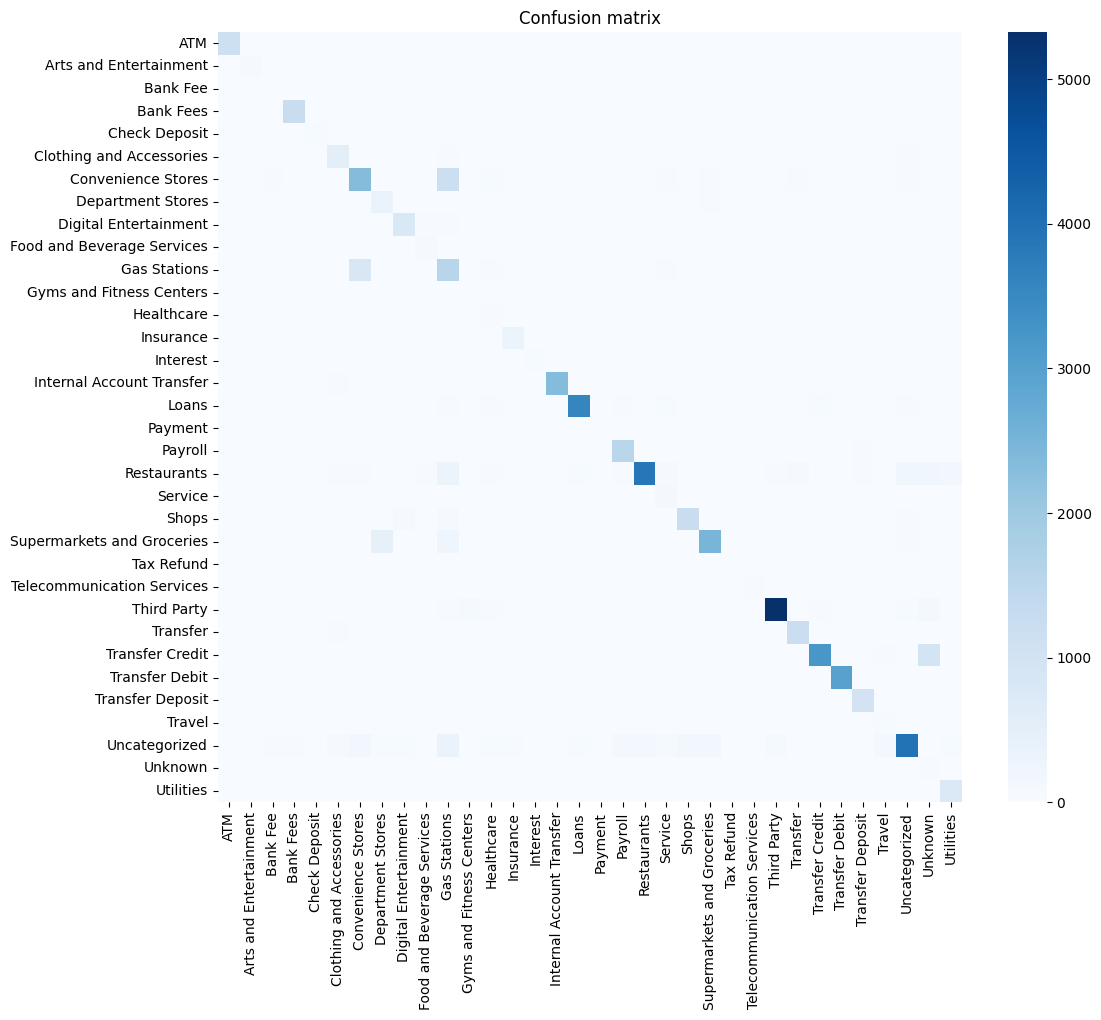

In [54]:
cm = confusion_matrix(y_test, y_pred, labels=pipe.classes_)
plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=False, fmt='d', cmap='Blues', xticklabels=pipe.classes_, yticklabels=pipe.classes_)
plt.xticks(rotation=90); plt.yticks(rotation=0)
plt.title("Confusion matrix")
plt.show()
